In [1]:
import dash
import dash_core_components as dcc
import dash_html_components as html

In [2]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.dashboard_objs as dashboard
import IPython.display
from IPython.display import Image

In [79]:
import pandas as pd
import numpy as np
import pickle
from start_script import *
from arima_script import *
from garch_script import *
from appliances_script import *

%matplotlib inline

In [80]:
plt.rc('figure', figsize=(18.0, 6.0))

In [81]:
pd.set_option('display.max_columns', None) 

In [82]:
df = load_building(545, '2015-5-01 00:00:00', '2016-10-31 00:00:00')
df_weather_austin = load_weather('austin')

In [26]:
#function to add all exogenous variables
def create_exog_endo(data, weather, building_id, length=1, total_length=30):
    
    start_train, end_train, start_test, end_test = find_dates(building_id, length, total_length)
    df_train, df_test = create_train_test(data, start_train, end_train, start_test, end_test, 24*length)

    car_charge = mean_car_charge(data, start_train,end_train)

    df_train['Time_Index'] = df_train.index.weekday_name+ df_train.index.hour.astype(str)
    df_train['Temperature'] = weather.loc[start_train:end_test, 'temperature']
    df_train['Humidity'] = weather.loc[start_train:end_test, 'humidity']

    for time in df_train.loc[start_test:end_test,:].index:
        df_train.loc[time,'car1'] = car_charge[df_train.loc[time,'Time_Index']]

    #fill missing values with mean
    df_train['Temperature'] = df_train.Temperature.fillna(np.mean(df_train['Temperature']))
    df_train['Humidity'] = df_train.Humidity.fillna(np.mean(df_train['Humidity']))

    exogenous = df_train.loc[start_train:,['Temperature','Humidity','car1']].astype(float)
    endogenous = df_train.loc[:,'Hourly_Usage'].astype(float)
    
    return df_train, exogenous, endogenous

In [77]:
#function to fit SARIMAX model with create_exog_endo
def fit_exog_arima_new(exogenous, endogenous):
    
    low_aic = gridsearch_arima(endogenous,exogenous)
    arima_model = sm.tsa.statespace.SARIMAX(endog=endogenous,
                                  exog = exogenous,
                                  trend=None,
                                  order=low_aic[0],
                                  seasonal_order=low_aic[1],
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
    arima_exog_results = arima_model.fit()
    
    return arima_exog_results

In [12]:
start_train, end_train, start_test, end_test = find_dates(545, 1, 30)
df_train, df_test = create_train_test(df, start_train, end_train, start_test, end_test, 24)

In [13]:
df_train, exogenous, endogenous = create_exog_endo(df, df_weather_austin, 545)

In [8]:
arima_exog_results = fit_exog_arima_new(exogenous, endogenous)

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [14]:
mse, rmse = add_forecast(arima_exog_results, df_test, df_train, start_test, end_test)

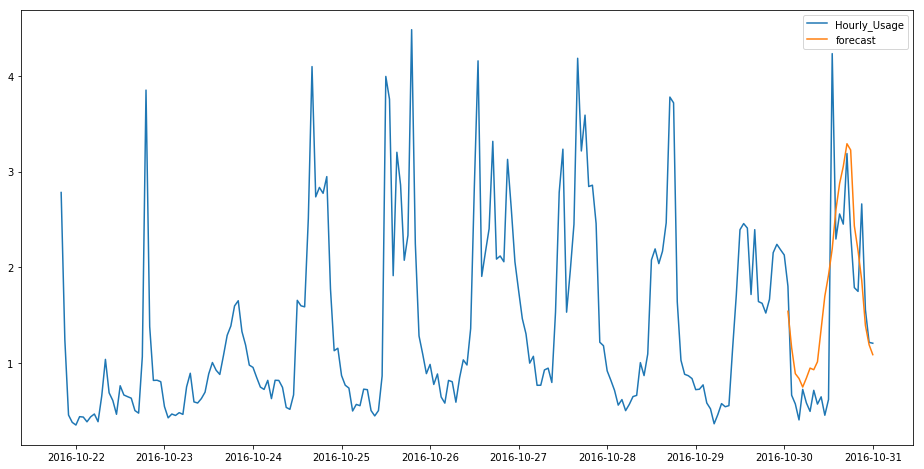

In [15]:
plot_forecast(df_train, 500)

24 hour forecast based on 30 days

In [16]:
trace_1 = go.Scatter(
    x = df_train.loc[start_train:end_train, 'Hourly_Usage'].index,
    y = df_train.loc[start_train:end_train, 'Hourly_Usage'].values
)

In [17]:
trace_2 = go.Scatter(
    x = df_train.loc[start_test:end_test, 'forecast'].index,
    y = df_train.loc[start_test:end_test, 'forecast'].values
)

In [18]:
data = [trace_1, trace_2]

In [19]:
py.iplot(data, filename='sarimax_545')

------

Predict next month's energy usage

In [23]:
start_train, end_train, start_test, end_test = find_dates(545, 15, 120)
df_train, df_test = create_train_test(df, start_train, end_train, start_test, end_test, 24*15)

In [28]:
df_train, exogenous, endogenous = create_exog_endo(df, df_weather_austin, 545, 15, 120)

In [29]:
arima_exog_month_results = fit_exog_arima_new(exogenous, endogenous)

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.5/dis

In [30]:
mse_month, rmse_month = add_forecast(arima_exog_month_results, df_test, df_train, start_test, end_test)

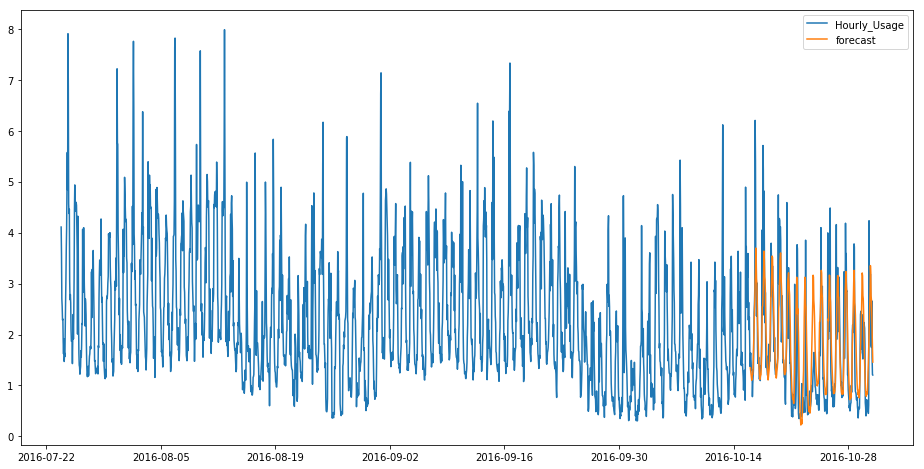

In [31]:
plot_forecast(df_train, 500)

In [71]:
trace_1 = go.Scatter(
    x = df_train.loc[start_train:end_test, 'Hourly_Usage'].index,
    y = df_train.loc[start_train:end_test, 'Hourly_Usage'].values
)

In [72]:
trace_2 = go.Scatter(
    x = df_train.loc[start_test:end_test, 'forecast'].index,
    y = df_train.loc[start_test:end_test, 'forecast'].values
)

In [73]:
data = [trace_1, trace_2]

In [74]:
py.iplot(data, filename='sarimax_545_month')

Compare appliance usage to neighborhood

In [44]:
average_appliances = pickle.load(open('pickle_files/average_appliance.p', 'rb'))
df_545 = pickle.load(open('pickle_files/df_545.p', 'rb'))

In [45]:
appliances = ['air1','bedroom1','dishwasher1','dryg1','furnace1','livingroom1','microwave1','refrigerator1']

In [46]:
appliances_545 = monthly_usage(545,appliances)

In [47]:
total_appliances_545 = {}

In [48]:
for appliance in appliances_545.keys():
    total_appliances_545[appliance]= sum(appliances_545[appliance].values)

In [49]:
total_appliances_545

{'air1': 467.25720000000013,
 'bedroom1': 16.787433333333354,
 'dishwasher1': 16.236383333333333,
 'dryg1': 7.8145166666666652,
 'furnace1': 175.0073666666662,
 'livingroom1': 68.521200000000093,
 'microwave1': 12.85586666666671,
 'refrigerator1': 41.574383333333344}

In [50]:
average_appliances

{'air1': 266.91244686692482,
 'bedroom1': 24.088478888888893,
 'dishwasher1': 11.447590041928724,
 'dryg1': 6.0303079710144951,
 'furnace1': 86.075987585034014,
 'livingroom1': 56.975688011695887,
 'microwave1': 7.6249509523809449,
 'refrigerator1': 64.59492322390571}

In [51]:
[x for x in total_appliances_545.values()]

[12.85586666666671,
 7.8145166666666652,
 41.574383333333344,
 68.521200000000093,
 16.787433333333354,
 467.25720000000013,
 175.0073666666662,
 16.236383333333333]

In [52]:
trace1 = go.Bar(
    x=[x for x in total_appliances_545.keys()],
    y=[y for y in total_appliances_545.values()],
    name='Your Home'
)

In [53]:
trace2 = go.Bar(
    x=[x for x in average_appliances.keys()],
    y=[y for y in average_appliances.values()],
    name='Homes in Your Neighborhood'
)

In [54]:
data = [trace1, trace2]
layout = go.Layout(
    barmode='group'
)

In [55]:
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='appliances_comparison')

In [56]:
df_545.index = pd.to_datetime(df_545.apply(strip_tz, axis=1))

In [57]:
df_545_new = df_545.loc['2016-10-01 00:00:00':'2016-10-31 00:00:00', ['air1','car1','bedroom1', 'dishwasher1',
                                                                     'dryg1','furnace1','livingroom1',
                                                                     'microwave1','refrigerator1']]

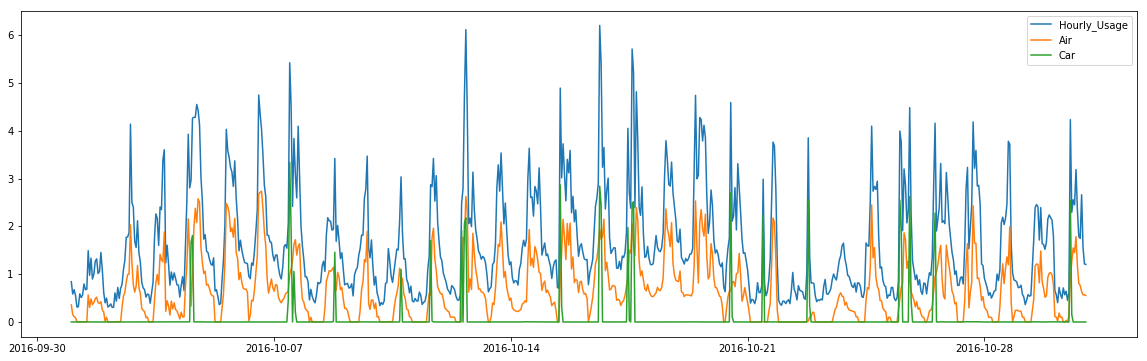

In [78]:
plt.subplots(1,1,figsize=(20,6))
plt.plot(df_train.loc['2016-10-01 00:00:00':'2016-10-31 00:00:00', 'Hourly_Usage'].index,
        df_train.loc['2016-10-01 00:00:00':'2016-10-31 00:00:00', 'Hourly_Usage'].values, label='Hourly_Usage')
plt.plot(df_545_new.index, df_545_new.air1, label='Air')
plt.plot(df_545_new.index, df_545_new.car1, label='Car')
plt.legend()

In [70]:
df_meta = pickle.load(open('pickle_files/df_meta_refined.p', 'rb'))

## Building the Dash App